Tips to navigate the notebook: Everytime that you need to verify a claim made in the report, search for the corresponding section name. For some sections (mainly related with the model itself), the code can also be located in the notebook that contains the pipeline or in transformers.py.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import category_encoders as ce
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score,precision_recall_curve
from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from category_encoders.binary import BinaryEncoder
import category_encoders as ce
import pickle
import json
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from transformers import (
    Test, 
    CreateCyclicalFeatures, 
    CategoricalDataCleaning, 
    NumericalDataCleaning
)



RANDOM_STATE = 1

In [2]:
def read_data() -> pd.DataFrame:
    """Imports the data.
    
    Returns:
        data (pd.DataFrame): DataFrame with the data. 
                             
    """
    path = os.path.join('data', 'train.csv')
    data = pd.read_csv(path)
    return data

train_df = read_data()
train_df.head()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,False,False,New Haven,10/01/2013 12:00:00 AM,NEW HAVEN,V,262,True,N,Stop Sign,31.0,H,W,M,True
1,False,False,State Police,10/01/2013 12:00:00 AM,WILLINGTON,V,1000002715,False,N,Other,29.0,M,W,M,False
2,False,False,Plymouth,10/01/2013 12:00:00 AM,Terryville,V,21,True,N,Speed Related,18.0,N,W,M,True
3,False,False,Plymouth,10/01/2013 12:00:00 AM,Plymouth,V,D1,True,N,Speed Related,52.0,N,W,F,False
4,False,False,Bethel,10/01/2013 12:00:00 AM,BETHEL,V,08M,True,N,Cell Phone,34.0,N,W,M,False


Section General Analysis

In [3]:
train_df.SubjectSexCode.value_counts()

M    1563180
F     910463
Name: SubjectSexCode, dtype: int64

Text(0.5, 0, 'Searched Vehicles')

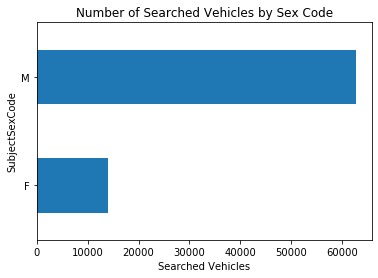

In [4]:
ax = train_df.groupby('SubjectSexCode')['VehicleSearchedIndicator'].sum().plot.barh(title = "Number of Searched Vehicles by Sex Code");
ax.set_xlabel("Searched Vehicles")

In [5]:
train_df.SubjectRaceCode.value_counts()

W    2018931
B     386325
A      48641
I      19746
Name: SubjectRaceCode, dtype: int64

In [6]:
train_df.groupby('SubjectRaceCode')['VehicleSearchedIndicator'].sum()

SubjectRaceCode
A      498.0
B    22501.0
I      220.0
W    53524.0
Name: VehicleSearchedIndicator, dtype: float64

In [7]:
53524/2018931

0.026511059565681047

In [8]:
22501/386325

0.058243706723613536

In [9]:
220/19746

0.011141497012053074

In [10]:
498/48641

0.010238276351226332

In [11]:
train_df.SubjectEthnicityCode.value_counts()

N    2099632
H     328450
M      45561
Name: SubjectEthnicityCode, dtype: int64

In [12]:
train_df.groupby('SubjectEthnicityCode')['VehicleSearchedIndicator'].sum()

SubjectEthnicityCode
H    17524.0
M      876.0
N    58343.0
Name: VehicleSearchedIndicator, dtype: float64

In [13]:
876/45561

0.019226970435240666

In [14]:
58343/2099632

0.027787250337201946

In [15]:
17524/328450

0.05335363068960268

In [16]:
train_df.ReportingOfficerIdentificationID.nunique()

8593

In [17]:
average_searched_vehicles_by_officer = train_df.groupby("ReportingOfficerIdentificationID")["VehicleSearchedIndicator"].mean().reset_index()
average_searched_vehicles_by_officer.columns = ["ReportingOfficerIdentificationID", "VehicleSearchedIndicator"]
average_searched_vehicles_by_officer = average_searched_vehicles_by_officer.set_index('ReportingOfficerIdentificationID', drop=False)
print(average_searched_vehicles_by_officer.VehicleSearchedIndicator.min())
print(average_searched_vehicles_by_officer.VehicleSearchedIndicator.max())

0.0
1.0


In [18]:
average_contraband_by_officer = train_df.groupby("ReportingOfficerIdentificationID")["ContrabandIndicator"].mean().reset_index()
average_contraband_by_officer.columns = ["ReportingOfficerIdentificationID", "ContrabandIndicator"]
average_contraband_by_officer = average_contraband_by_officer.set_index('ReportingOfficerIdentificationID', drop=False)
print(average_contraband_by_officer.ContrabandIndicator.min())
print(average_contraband_by_officer.ContrabandIndicator.max())

0.0
1.0


In [19]:
train_df['Department Name'].nunique()

122

In [20]:
average_searched_vehicles_by_department = train_df.groupby("Department Name")["VehicleSearchedIndicator"].mean().reset_index()
average_searched_vehicles_by_department.columns = ["Department Name", "VehicleSearchedIndicator"]
average_searched_vehicles_by_department = average_searched_vehicles_by_department.set_index('Department Name', drop=False)
print(average_searched_vehicles_by_department.VehicleSearchedIndicator.min())
print(average_searched_vehicles_by_department.VehicleSearchedIndicator.max())

0.0
0.1966724219117878


In [21]:
average_contraband_by_department = train_df.groupby("Department Name")["ContrabandIndicator"].mean().reset_index()
average_contraband_by_department.columns = ["Department Name", "ContrabandIndicator"]
average_contraband_by_department = average_contraband_by_department.set_index('Department Name', drop=False)
print(average_contraband_by_department.ContrabandIndicator.min())
print(average_contraband_by_department.ContrabandIndicator.max())

0.0
0.1111111111111111


In [22]:
train_df['InterventionDateTime'] = pd.to_datetime(train_df['InterventionDateTime'], format='%m/%d/%Y %I:%M:%S %p')

In [23]:
train_df['InterventionDateMonth'] = train_df['InterventionDateTime'].dt.month

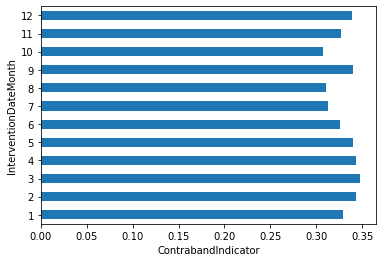

In [24]:
average_contraband_by_month = train_df.loc[train_df.VehicleSearchedIndicator == True].groupby("InterventionDateMonth")["ContrabandIndicator"].mean().reset_index()
average_contraband_by_month.columns = ["InterventionDateMonth", "ContrabandIndicator"]
average_contraband_by_month = average_contraband_by_month.set_index('InterventionDateMonth', drop=False)
average_contraband_by_month.ContrabandIndicator.plot(label="ContrabandIndicator", kind='barh')
plt.xlabel('ContrabandIndicator')
axis = plt.gca();

Section Business Question Analysis and Business questions technical support and Conclusions and Recommendations

In [25]:
precision_male = train_df.ContrabandIndicator[np.equal(train_df.SubjectSexCode, "M")].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectSexCode, "M")].sum()
precision_female = train_df.ContrabandIndicator[np.equal(train_df.SubjectSexCode, "F")].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectSexCode, "F")].sum()
precision_hispanic = train_df.ContrabandIndicator[np.equal(train_df.SubjectEthnicityCode, "H")].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectEthnicityCode, "H")].sum()
precision_middle_east = train_df.ContrabandIndicator[np.equal(train_df.SubjectEthnicityCode, "M")].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectEthnicityCode, "M")].sum()
precision_not_applicable_ethnicity = train_df.ContrabandIndicator[np.equal(train_df.SubjectEthnicityCode, "N")].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectEthnicityCode, "N")].sum()
precision_white = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "W")].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "W")].sum()
precision_black = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "B")].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "B")].sum()
precision_asian = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "A")].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "A")].sum()
precision_indian = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "I")].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "I")].sum()
print(precision_male, precision_female)
print(precision_hispanic, precision_middle_east, precision_not_applicable_ethnicity)
print(precision_white, precision_black, precision_asian, precision_indian)

0.36895000478575757 0.3708472647079747
0.3199041314768318 0.2945205479452055 0.3852561575510344
0.38422016291756966 0.3344740233767388 0.357429718875502 0.32727272727272727


In [26]:
from itertools import combinations 
for i in np.unique(train_df['Department Name'].values):
    precision_male = train_df.ContrabandIndicator[np.equal(train_df.SubjectSexCode, "M") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectSexCode, "M") & np.equal(train_df['Department Name'], i)].sum()
    precision_female = train_df.ContrabandIndicator[np.equal(train_df.SubjectSexCode, "F") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectSexCode, "F") & np.equal(train_df['Department Name'], i)].sum()
    precision_hispanic = train_df.ContrabandIndicator[np.equal(train_df.SubjectEthnicityCode, "H") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectEthnicityCode, "H") & np.equal(train_df['Department Name'], i)].sum()
    precision_middle_east = train_df.ContrabandIndicator[np.equal(train_df.SubjectEthnicityCode, "M") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectEthnicityCode, "M") & np.equal(train_df['Department Name'], i)].sum()
    precision_not_applicable_ethnicity = train_df.ContrabandIndicator[np.equal(train_df.SubjectEthnicityCode, "N") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectEthnicityCode, "N") & np.equal(train_df['Department Name'], i)].sum()
    precision_white = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "W") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "W") & np.equal(train_df['Department Name'], i)].sum()
    precision_black = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "B") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "B") & np.equal(train_df['Department Name'], i)].sum()
    precision_indian = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "I") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "I") & np.equal(train_df['Department Name'], i)].sum()
    precision_asian = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "A") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "A") & np.equal(train_df['Department Name'], i)].sum()
    test_list = [precision_male, precision_female]
    test_list_2 = [precision_hispanic, precision_middle_east, precision_not_applicable_ethnicity]
    test_list_3 = [precision_white, precision_black, precision_indian, precision_asian]
    res = max(combinations(test_list, 2), key = lambda sub: abs(sub[0]-sub[1]))
    res_2 = max(combinations(test_list_2, 2), key = lambda sub: abs(sub[0]-sub[1]))
    res_3 = max(combinations(test_list_3, 2), key = lambda sub: abs(sub[0]-sub[1]))
    if((abs(res[0]-res[1]) <= 0.05) & (abs(res_2[0]-res_2[1]) <= 0.05) & (abs(res_3[0]-res_3[1]) <= 0.05)):
        print(i)

C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in longlong_scalars
  after removing the cwd from sys.path.
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
  """
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in longlong_scalars
  
C:\Anaconda3\env

In [52]:
differences_of_bigger_than_0dot9 = []
for i in np.unique(train_df['Department Name'].values):
    if train_df.VehicleSearchedIndicator[np.equal(train_df['Department Name'], i)].sum() > 100:
        precision_male = train_df.ContrabandIndicator[np.equal(train_df.SubjectSexCode, "M") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectSexCode, "M") & np.equal(train_df['Department Name'], i)].sum()
        precision_female = train_df.ContrabandIndicator[np.equal(train_df.SubjectSexCode, "F") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectSexCode, "F") & np.equal(train_df['Department Name'], i)].sum()
        precision_hispanic = train_df.ContrabandIndicator[np.equal(train_df.SubjectEthnicityCode, "H") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectEthnicityCode, "H") & np.equal(train_df['Department Name'], i)].sum()
        precision_middle_east = train_df.ContrabandIndicator[np.equal(train_df.SubjectEthnicityCode, "M") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectEthnicityCode, "M") & np.equal(train_df['Department Name'], i)].sum()
        precision_not_applicable_ethnicity = train_df.ContrabandIndicator[np.equal(train_df.SubjectEthnicityCode, "N") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectEthnicityCode, "N") & np.equal(train_df['Department Name'], i)].sum()
        precision_white = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "W") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "W") & np.equal(train_df['Department Name'], i)].sum()
        precision_black = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "B") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "B") & np.equal(train_df['Department Name'], i)].sum()
        precision_indian = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "I") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "I") & np.equal(train_df['Department Name'], i)].sum()
        precision_asian = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "A") & np.equal(train_df['Department Name'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "A") & np.equal(train_df['Department Name'], i)].sum()
        test_list = [precision_male, precision_female]
        test_list_2 = [precision_hispanic, precision_middle_east, precision_not_applicable_ethnicity]
        test_list_3 = [precision_white, precision_black, precision_indian, precision_asian]
        res = max(combinations(test_list, 2), key = lambda sub: abs(sub[0]-sub[1]))
        res_2 = max(combinations(test_list_2, 2), key = lambda sub: abs(sub[0]-sub[1]))
        res_3 = max(combinations(test_list_3, 2), key = lambda sub: abs(sub[0]-sub[1]))
        if(((abs(res[0]-res[1]) > 0.9)) | ((abs(res_2[0]-res_2[1]) > 0.9)) | ((abs(res_3[0]-res_3[1]) > 0.9))):
            differences_of_bigger_than_0dot9.append(i)
print(differences_of_bigger_than_0dot9)

C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  import sys
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in longlong_scalars
  if sys.path[0] == '':
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in longlong_scalars
  if sys.path[0] == '':
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in longlong_scalars
  import sys


['CSP Troop I', 'Darien', 'Enfield', 'Meriden', 'Middletown', 'Orange', 'Rocky Hill']


In [28]:
from itertools import combinations 
differences_of_bigger_than_0dot9_officer = []
ax = train_df['ReportingOfficerIdentificationID'].values
ax = [str(i) for i in ax]
ax = np.unique(ax)

for i in ax:
    if train_df.VehicleSearchedIndicator[np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum() > 100:
        precision_male = train_df.ContrabandIndicator[np.equal(train_df.SubjectSexCode, "M") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectSexCode, "M") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()
        precision_female = train_df.ContrabandIndicator[np.equal(train_df.SubjectSexCode, "F") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectSexCode, "F") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()
        precision_hispanic = train_df.ContrabandIndicator[np.equal(train_df.SubjectEthnicityCode, "H") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectEthnicityCode, "H") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()
        precision_middle_east = train_df.ContrabandIndicator[np.equal(train_df.SubjectEthnicityCode, "M") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectEthnicityCode, "M") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()
        precision_not_applicable_ethnicity = train_df.ContrabandIndicator[np.equal(train_df.SubjectEthnicityCode, "N") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectEthnicityCode, "N") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()
        precision_white = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "W") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "W") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()
        precision_black = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "B") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "B") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()
        precision_indian = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "I") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "I") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()
        precision_asian = train_df.ContrabandIndicator[np.equal(train_df.SubjectRaceCode, "A") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()/train_df.VehicleSearchedIndicator[np.equal(train_df.SubjectRaceCode, "A") & np.equal(train_df['ReportingOfficerIdentificationID'], i)].sum()
        test_list = [precision_male, precision_female]
        test_list_2 = [precision_hispanic, precision_middle_east, precision_not_applicable_ethnicity]
        test_list_3 = [precision_white, precision_black, precision_indian, precision_asian]
        res = max(combinations(test_list, 2), key = lambda sub: abs(sub[0]-sub[1]))
        res_2 = max(combinations(test_list_2, 2), key = lambda sub: abs(sub[0]-sub[1]))
        res_3 = max(combinations(test_list_3, 2), key = lambda sub: abs(sub[0]-sub[1]))
        if(((abs(res[0]-res[1]) > 0.9) & ((abs(res[0]-res[1]) <= 1))) | ((abs(res_2[0]-res_2[1]) > 0.9) & (abs(res_2[0]-res_2[1]) <= 1)) | ((abs(res_3[0]-res_3[1]) > 0.9) & (abs(res_3[0]-res_3[1]) <=1))):
            differences_of_bigger_than_0dot9_officer.append(i)
print(differences_of_bigger_than_0dot9_officer)

C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in longlong_scalars
  if sys.path[0] == '':
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in longlong_scalars
  app.launch_new_instance()
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in longlong_scalars
  app.launch_new_instance()
C:\Anaconda3\envs\capstone_env\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in longlong_scalars


['1000001949', '1000002608', '179', '199', '256', '30233', '570']


In [29]:
precision_global = train_df.ContrabandIndicator.sum()/train_df.VehicleSearchedIndicator.sum()
precision_global

0.3692975255072124

Section Model expected outcomes overview

In [30]:
train_df[train_df['Department Name'] == 'WCSU'].SubjectEthnicityCode.value_counts()

N    67
H    28
M     1
Name: SubjectEthnicityCode, dtype: int64

Section Model specifications.
Regarding this section, the code is in the notebook that contains the pipeline and in transformers.py. Please note that some phrases (e.g. the binary encoder gave a little improvement in roc_auc compared to the ordinal encoder) can't be confirmed in the notebook. You will have to trust me on those claims :) both sources of code contain only the final version 

Section Analysis of expected outcomes based on training set. The code is in the notebook that contains the pipeline

Section Alternatives considered. As described earlier, there is no code to prove this section

Section Model Dataset technical analysis

In [31]:
train_df.dtypes

VehicleSearchedIndicator                      bool
ContrabandIndicator                           bool
Department Name                             object
InterventionDateTime                datetime64[ns]
InterventionLocationName                    object
InterventionReasonCode                      object
ReportingOfficerIdentificationID            object
ResidentIndicator                             bool
SearchAuthorizationCode                     object
StatuteReason                               object
SubjectAge                                 float64
SubjectEthnicityCode                        object
SubjectRaceCode                             object
SubjectSexCode                              object
TownResidentIndicator                         bool
InterventionDateMonth                        int64
dtype: object

In [32]:
# percentile list 
perc =[.20, .40, .60, .80] 
  
# list of dtypes to include 
include =['float64']

# calling describe method 
desc = train_df.describe(percentiles = perc, include = include) 
desc 

,SubjectAge
count,2.473643e+06
mean,3.867566e+01
std,1.496720e+01
min,1.000000e+00
20%,2.400000e+01
40%,3.200000e+01
50%,3.600000e+01
60%,4.100000e+01
80%,5.300000e+01
max,9.900000e+01


In [33]:
np.unique(train_df.SubjectAge.values)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90., 91.,
       92., 93., 94., 95., 96., 97., 98., 99.])

In [34]:
include =['object']
  
# calling describe method 
desc = train_df.describe(percentiles = perc, include = include) 
desc 

,Department Name,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,SearchAuthorizationCode,StatuteReason,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode
count,2473643,2473607,2473641,2473641,2473633,2473136,2473643,2473643,2473643
unique,122,2504,4,8593,4,18,3,4,2
top,State Police,NEW HAVEN,V,790642042,N,Speed Related,N,W,M
freq,322003,81216,2179595,8524,2384830,681119,2099632,2018931,1563180


In [35]:
include =['bool']
  
# calling describe method 
desc = train_df.describe(percentiles = perc, include = include) 
desc 

,VehicleSearchedIndicator,ContrabandIndicator,ResidentIndicator,TownResidentIndicator
count,2473643,2473643,2473643,2473643
unique,2,2,2,2
top,False,False,True,False
freq,2396900,2445302,2131034,1702011


In [36]:
train_df.VehicleSearchedIndicator.value_counts()

False    2396900
True       76743
Name: VehicleSearchedIndicator, dtype: int64

In [37]:
7624/(237607+7624)

0.031089054809546917

In [38]:
train_df.ContrabandIndicator.value_counts()

False    2445302
True       28341
Name: ContrabandIndicator, dtype: int64

In [39]:
2839/(242392+2839)

0.011576839795947494

In [40]:
train_df[train_df.VehicleSearchedIndicator == True].ContrabandIndicator.value_counts()

False    51225
True     25518
Name: ContrabandIndicator, dtype: int64

In [41]:
2539/(5085+2539)

0.3330272822665268

In [42]:
train_df.isnull().sum()

VehicleSearchedIndicator              0
ContrabandIndicator                   0
Department Name                       0
InterventionDateTime                  0
InterventionLocationName             36
InterventionReasonCode                2
ReportingOfficerIdentificationID      2
ResidentIndicator                     0
SearchAuthorizationCode              10
StatuteReason                       507
SubjectAge                            0
SubjectEthnicityCode                  0
SubjectRaceCode                       0
SubjectSexCode                        0
TownResidentIndicator                 0
InterventionDateMonth                 0
dtype: int64

In [43]:
train_df.shape

(2473643, 16)

In [44]:
duplicate_rows_df = train_df[train_df.duplicated()]
duplicate_rows_df.shape

(204756, 16)

In [45]:
train_df.shape

(2473643, 16)

In [46]:
204756/2473643

0.08277508112528768

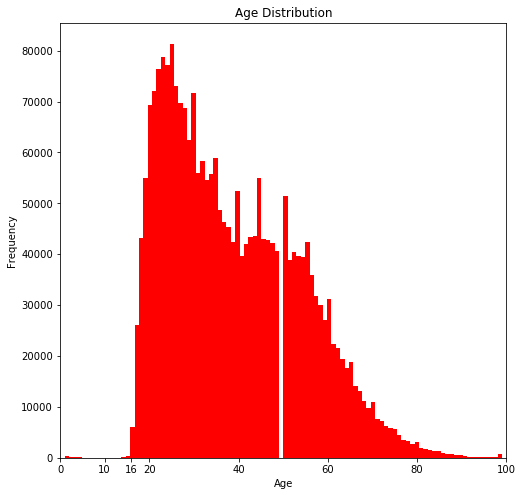

In [47]:
inches_wide = 8
inches_high = 8
plt.rcParams["figure.figsize"] = [inches_wide, inches_high]
ax = train_df.SubjectAge.plot.hist(xlim=(0,100), bins=100, color='red', xticks = [0, 10, 16, 20, 40, 60, 80, 100], title = "Age Distribution");
ax.set_xlabel("Age")
axis = plt.gca();

In [48]:
corr = train_df.corr()
corr

,VehicleSearchedIndicator,ContrabandIndicator,ResidentIndicator,SubjectAge,TownResidentIndicator,InterventionDateMonth
VehicleSearchedIndicator,1.000000,0.539806,0.026562,-0.097302,0.032913,-0.007608
ContrabandIndicator,0.539806,1.000000,0.014080,-0.071966,0.015359,-0.006420
ResidentIndicator,0.026562,0.014080,1.000000,-0.002696,0.156544,-0.011588
SubjectAge,-0.097302,-0.071966,-0.002696,1.000000,0.023212,0.000861
TownResidentIndicator,0.032913,0.015359,0.156544,0.023212,1.000000,-0.017283
InterventionDateMonth,-0.007608,-0.006420,-0.011588,0.000861,-0.017283,1.000000


In [49]:
train_df[train_df.VehicleSearchedIndicator == False].ContrabandIndicator.value_counts()

False    2394077
True        2823
Name: ContrabandIndicator, dtype: int64

In [50]:
cardinality = train_df.describe(exclude=np.number).T
cardinality

,count,unique,top,freq,first,last
VehicleSearchedIndicator,2473643,2,False,2396900,NaT,NaT
ContrabandIndicator,2473643,2,False,2445302,NaT,NaT
Department Name,2473643,122,State Police,322003,NaT,NaT
InterventionDateTime,2473643,1450465,2014-03-07 00:00:00,270,2013-10-01,2018-05-16 02:02:00
InterventionLocationName,2473607,2504,NEW HAVEN,81216,NaT,NaT
InterventionReasonCode,2473641,4,V,2179595,NaT,NaT
ReportingOfficerIdentificationID,2473641,8593,790642042,8524,NaT,NaT
ResidentIndicator,2473643,2,True,2131034,NaT,NaT
SearchAuthorizationCode,2473633,4,N,2384830,NaT,NaT
StatuteReason,2473136,18,Speed Related,681119,NaT,NaT


In [51]:
train_df[train_df.SubjectEthnicityCode == 'M'].tail()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator,InterventionDateMonth
855038,False,False,New Britain,2015-03-31 20:46:00,New Britain,V,DGC0471,True,N,Other/Error,55.0,M,W,F,True,3
855062,False,False,Monroe,2015-03-31 21:19:00,MONROE,V,1000101,True,N,Moving Violation,40.0,M,A,M,False,3
855088,False,False,Hamden,2015-03-31 21:37:00,Hamden,V,100000556,True,N,Registration,29.0,M,W,M,False,3
855140,False,False,State Police,2015-03-31 22:42:00,TOLLAND,E,389731444,True,N,Defective Lights,24.0,M,W,M,False,3
855194,False,False,State Police,2015-03-31 23:42:00,KILLINGLY,E,1000002270,True,N,Other/Error,29.0,M,W,F,True,3


Section Model technical analysis. Code is in the notebook that contains the pipeline